# 01. GAN with MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# GPU 체크
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load MNIST Data

In [4]:
mnist_train = dsets.MNIST(root='~/.pytorch/MNIST_data/',
                          train=True,
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          transform=transforms.ToTensor(),                          
                          download=True)

In [5]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

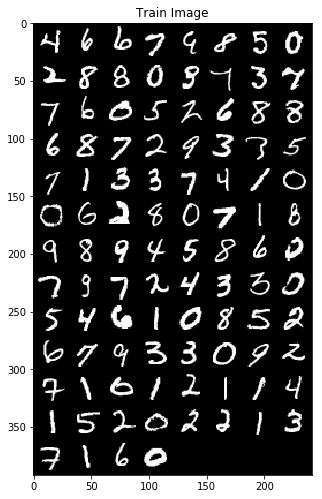

In [7]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## Define Model

In [8]:
image_size = 28*28
latent_size = 100

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.discriminator = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, image_size)
        out = self.discriminator(x)
        return out

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(latent_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, image_size),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.generator(x)
        out = out.view(-1, 1, 28, 28)
        return out

In [11]:
D = Discriminator().to(device)
G = Generator().to(device)

In [12]:
print(D(images.to(device)).shape)

z = torch.randn(batch_size, latent_size).to(device)
print(G(z).shape)

torch.Size([100, 1])
torch.Size([100, 1, 28, 28])


## Training

In [13]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()   # real or fake
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
    else :
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, target_tensor.to(device))

In [14]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [15]:
num_epochs = 500

for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        
        # ---------------------------------------
        # Train D
        
        prob_real = D(images)
        D_loss_real = gan_loss(prob_real, True)

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = (D_loss_real + D_loss_fake) / 2
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        # ---------------------------------------
        # Train G
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        # ---------------------------------------
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.item(), G_loss.item()))

Epoch [1/500], lter [600/600], D_Loss: 0.1126, G_Loss: 5.8706
Epoch [2/500], lter [600/600], D_Loss: 0.1873, G_Loss: 5.9597
Epoch [3/500], lter [600/600], D_Loss: 0.0595, G_Loss: 17.5750
Epoch [4/500], lter [600/600], D_Loss: 0.0449, G_Loss: 11.3622
Epoch [5/500], lter [600/600], D_Loss: 0.1211, G_Loss: 9.2461
Epoch [6/500], lter [600/600], D_Loss: 0.0516, G_Loss: 6.0171
Epoch [7/500], lter [600/600], D_Loss: 0.0759, G_Loss: 5.6751
Epoch [8/500], lter [600/600], D_Loss: 0.0924, G_Loss: 6.2010
Epoch [9/500], lter [600/600], D_Loss: 0.1458, G_Loss: 6.3318
Epoch [10/500], lter [600/600], D_Loss: 0.1009, G_Loss: 5.6562
Epoch [11/500], lter [600/600], D_Loss: 0.1280, G_Loss: 4.6962
Epoch [12/500], lter [600/600], D_Loss: 0.0699, G_Loss: 6.3263
Epoch [13/500], lter [600/600], D_Loss: 0.0817, G_Loss: 5.1329
Epoch [14/500], lter [600/600], D_Loss: 0.1065, G_Loss: 6.0885
Epoch [15/500], lter [600/600], D_Loss: 0.1329, G_Loss: 6.9320
Epoch [16/500], lter [600/600], D_Loss: 0.0904, G_Loss: 5.5063

Epoch [258/500], lter [600/600], D_Loss: 0.3337, G_Loss: 1.8239
Epoch [259/500], lter [600/600], D_Loss: 0.3801, G_Loss: 1.8718
Epoch [260/500], lter [600/600], D_Loss: 0.3872, G_Loss: 1.7625
Epoch [261/500], lter [600/600], D_Loss: 0.4336, G_Loss: 1.9589
Epoch [262/500], lter [600/600], D_Loss: 0.4541, G_Loss: 2.1489
Epoch [263/500], lter [600/600], D_Loss: 0.3566, G_Loss: 1.7911
Epoch [264/500], lter [600/600], D_Loss: 0.3818, G_Loss: 2.0153
Epoch [265/500], lter [600/600], D_Loss: 0.4621, G_Loss: 1.7835
Epoch [266/500], lter [600/600], D_Loss: 0.4123, G_Loss: 1.6034
Epoch [267/500], lter [600/600], D_Loss: 0.4939, G_Loss: 2.2121
Epoch [268/500], lter [600/600], D_Loss: 0.3685, G_Loss: 1.4693
Epoch [269/500], lter [600/600], D_Loss: 0.3777, G_Loss: 1.8335
Epoch [270/500], lter [600/600], D_Loss: 0.3637, G_Loss: 1.8701
Epoch [271/500], lter [600/600], D_Loss: 0.3947, G_Loss: 1.7871
Epoch [272/500], lter [600/600], D_Loss: 0.4521, G_Loss: 1.6931
Epoch [273/500], lter [600/600], D_Loss:

## Generate Image

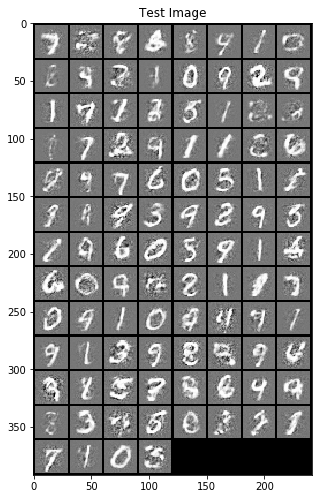

In [16]:
z = torch.randn(batch_size, latent_size).to(device)
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")